In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
from pathlib import Path
Path("/gdrive/MyDrive/Colab Notebooks/").mkdir(parents=True, exist_ok=True)
%ls /gdrive/MyDrive/Colab\ Notebooks/

Mounted at /gdrive
/gdrive
correlation_heatmap.png                    obesity_frequent_itemsets_fpgrowth.csv
data_encoded.csv                           obesity_test.csv
distribution/                              obesity_test_X.csv
「FP-growth.ipynb」的副本                  obesity_test_y.csv
frequentitem_set.csv                       obesity_train.csv
frequent_itemsets.csv                      obesity_train_X.csv
frequent_itemsets_updated_file.csv         obesity_train_y.csv
low_variance_features.png                  outlier/
mlxtend_ECLAT.ipynb                        outlier_flagging.png
obesity_association_rules_eclat.csv        processed_train_X.csv
obesity_association_rules_eclat.gsheet     processed_train_y.csv
obesity_association_rules_fpgrowth.csv     pyECLAT.ipynb
obesity_association_rules_fpgrowth.gsheet  summary/
ObesityDataSet_raw_and_data_sinthetic.csv  supports.csv
obesity_frequent_itemsets_eclat.csv        target_balance.png
obesity_frequent_itemsets_eclat.gsheet     「Term_Pro

In [2]:
import pandas as pd
# Load the training dataset
X = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/processed_train_X.csv')
y = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/processed_train_y.csv')
Path("/gdrive/MyDrive/Colab Notebooks/evaluation/").mkdir(parents=True, exist_ok=True)

In [3]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
def evaluate_model(model, X, y):
    # Ensure y is a Series
    y = y.squeeze()  # Converts y to a Series if it's a single-column DataFrame

    # Convert y to numeric if it's not already
    if y.dtype == 'object' or y.dtype == 'category':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Wrap the model with OneVsRestClassifier for multiclass probability prediction
    model = OneVsRestClassifier(model)

    # Perform 5-fold cross-validation with both AUROC and F1-macro scoring
    cv = StratifiedKFold(n_splits=5)
    # Initialize lists to store scores
    auroc_scores = []
    f1_macro_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = {i: [] for i in np.unique(y)}  # Store TPRs for each class

    for train_idx, test_idx in cv.split(X, y):
        # Fit model on training data
        model.fit(X.iloc[train_idx], y[train_idx])

        # Predict probabilities on test data
        y_pred_prob = model.predict_proba(X.iloc[test_idx])

        # Calculate AUROC for this fold
        auroc = roc_auc_score(y[test_idx], y_pred_prob, multi_class='ovr', average='macro')
        auroc_scores.append(auroc)

        # Calculate F1 Macro for this fold
        y_pred = model.predict(X.iloc[test_idx])
        f1_macro = f1_score(y[test_idx], y_pred, average='macro')
        f1_macro_scores.append(f1_macro)

        # Calculate ROC curve for each class
        for i, class_label in enumerate(np.unique(y)):
            fpr, tpr, _ = roc_curve(y[test_idx] == class_label, y_pred_prob[:, i])
            tprs[class_label].append(np.interp(mean_fpr, fpr, tpr))
            tprs[class_label][-1][0] = 0.0

    # Calculate mean scores
    avg_auroc = np.mean(auroc_scores)
    avg_f1_macro = np.mean(f1_macro_scores)

    # Calculate mean TPR for each class
    mean_tprs = {class_label: np.mean(tpr_list, axis=0) for class_label, tpr_list in tprs.items()}
    for tpr in mean_tprs.values():
        tpr[-1] = 1.0

    return avg_auroc, avg_f1_macro, mean_fpr, mean_tprs

In [4]:
Path("/gdrive/MyDrive/Colab Notebooks/evaluation/importances/").mkdir(parents=True, exist_ok=True)
def save_top_features(model, X, model_name):
    # Calculate feature importance if the model supports it
    if hasattr(model, "feature_importances_"):
        feature_importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(20)

        # Save to CSV
        filename = f"/gdrive/MyDrive/Colab Notebooks/evaluation/importances/{model_name}_top_20_features.csv"
        feature_importances.to_csv(filename, index=False)
        print(f"Top 20 features for {model_name} saved to {filename}")
        return feature_importances
    else:
        print(f"Model {model_name} does not support feature importances.")
        return None

In [5]:
import joblib
Path("/gdrive/MyDrive/Colab Notebooks/models/").mkdir(parents=True, exist_ok=True)
def save_model(model, model_name):
    # Save the trained model to a file
    filename = f"/gdrive/MyDrive/Colab Notebooks/models/{model_name}_model.joblib"
    joblib.dump(model, filename)
    print(f"Model {model_name} saved to {filename}")

In [6]:
import matplotlib.pyplot as plt
def plot_results(results):
    # Prepare data for plotting
    models = list(results.keys())
    f1_scores = [results[model]['F1_Macro'] for model in models]
    plt.figure(figsize=(8, 6))
    for model in models:
        # Extract FPR and TPR for the current model
        fpr = results[model]['mean_fpr']
        tprs = results[model]['mean_tpr']

        for class_label, mean_tpr in tprs.items():
            # Calculate AUC for the ROC curve of the current class
            roc_auc = auc(mean_fpr, mean_tpr)
            # Plot ROC curve for the current class
            plt.plot(mean_fpr, mean_tpr, label=f'{model} - Class {class_label} (AUROC = {roc_auc:.3f})')


    # Plot ROC curve
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance Level")
    plt.xlabel('False Positive Rate [%]')
    plt.ylabel('True Positive Rate [%]')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'/gdrive/MyDrive/Colab Notebooks/evaluation/AUROC_plot.png')

    # Plot Macro F1-Score
    plt.figure(figsize=(10, 5))
    plt.bar(models, f1_scores, color='lightgreen')
    plt.title("Average Macro F1-Score by Model")
    plt.xlabel("Model")
    plt.ylabel("Average Macro F1-Score")
    plt.tight_layout()
    plt.savefig('/gdrive/MyDrive/Colab Notebooks/evaluation/f1_score_plot.png')

Evaluating RandomForest...
RandomForest - AUROC: 0.8988, Macro F1-Score: 0.5877
Top 20 features for RandomForest saved to /gdrive/MyDrive/Colab Notebooks/evaluation/importances/RandomForest_top_20_features.csv
                               Feature  Importance
3                                  Age    0.185130
7   family_history_with_overweight_yes    0.139580
6                          Gender_Male    0.101170
12                     CAEC_Frequently    0.093236
13                      CAEC_Sometimes    0.082425
1                                  NCP    0.064939
11                            FAVC_yes    0.061763
10                             CALC_no    0.046844
5                                 FCVC    0.040517
9                       CALC_Sometimes    0.037861
4                                  FAF    0.034612
0                                 CH2O    0.032178
14                             CAEC_no    0.030265
2                                  TUE    0.029334
15                       

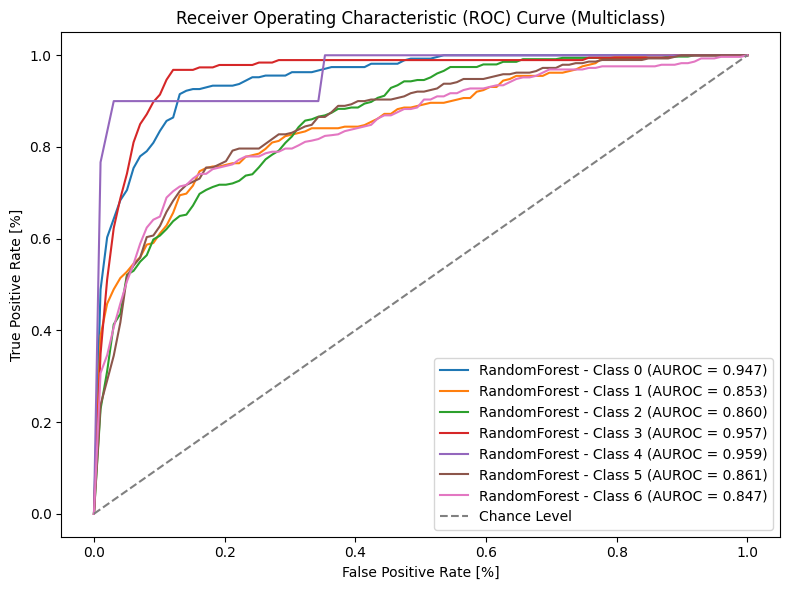

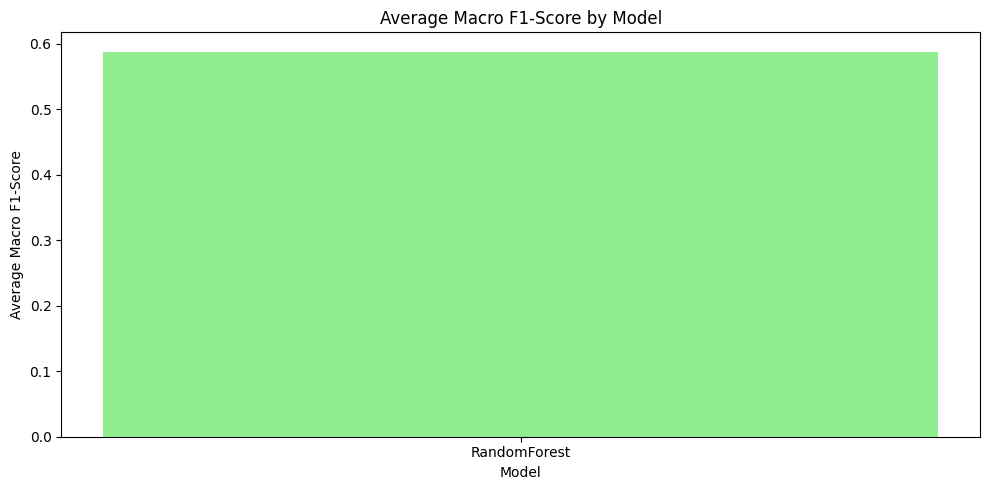

In [7]:
from sklearn.ensemble import RandomForestClassifier

models_to_run=['RandomForest']
# Dictionary to store results
results = {}
# Define models
model_dict = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=50, max_depth=5)
}
# Evaluate specified models
for model_name in models_to_run:
    if model_name in model_dict:
        print(f"Evaluating {model_name}...")
        model = model_dict[model_name]
        model.fit(X, y.values.ravel())
        avg_auroc, avg_f1_macro, mean_fpr, mean_tpr = evaluate_model(model, X, y)
        results[model_name] = {'AUROC': avg_auroc, 'F1_Macro': avg_f1_macro, 'mean_fpr': mean_fpr, 'mean_tpr': mean_tpr}
        print(f"{model_name} - AUROC: {avg_auroc:.4f}, Macro F1-Score: {avg_f1_macro:.4f}")
        # Save top features
        top_features = save_top_features(model, X, model_name)
        if top_features is not None:
            print(top_features)

        # Save the trained model
        save_model(model, model_name)
# Plot results
plot_results(results)